In [1]:
%matplotlib notebook
#import matplotlib.pyplot as plt
#import numpy as np
import urllib.request
import gzip
import os

def load_covtype_dataset():
    '''Downloads the Cover Type dataset from UCI repository, returning a file handle'''
    CURRENT_DIR = os.getcwd()
    COVTYPE_FILENAME = 'covtype.data'
    COVTYPE_DATA_PATH = os.path.join(CURRENT_DIR, COVTYPE_FILENAME)
    COVTYPE_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz'
    if os.path.isfile(COVTYPE_DATA_PATH):
        print('Using local cached copy in', COVTYPE_DATA_PATH)
    else:
        print('Dataset not found locally. Downloading in', COVTYPE_DATA_PATH)
        with urllib.request.urlopen(COVTYPE_URL) as response:
            with gzip.GzipFile(fileobj=response) as uncompressed, open(COVTYPE_DATA_PATH, 'wb') as out_file:
                file_header = uncompressed.read()
                out_file.write(file_header)
    return COVTYPE_DATA_PATH


In [2]:
covtype_file = load_covtype_dataset()

Using local cached copy in /home/jovyan/work/covtype.data


In [3]:
import pandas as pd
import numpy as np

df_covtype = pd.read_csv(covtype_file, header=None)

In [4]:
df_covtype.describe()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,...,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,...,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060,2.051471
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,...,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791,1.396504
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


In [5]:
def features_renaming(df_covtype):
    '''Rename each column to meaningful labels'''
    # First step: rename the first 14 columns
    first_fourteen_old_feature_names = df_covtype.columns[np.arange(0,14)]
    first_fourteen_new_feature_names = ['Elevation', 'Aspect', 'Slope',
                                        'Horizontal_Distance_To_Hydrology',
                                        'Vertical_Distance_To_Hydrology',
                                        'Horizontal_Distance_To_Roadways',
                                        'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
                                        'Horizontal_Distance_To_Fire_Points',
                                        'Wilderness_Area_1', 'Wilderness_Area_2',
                                        'Wilderness_Area_3', 'Wilderness_Area_4']
    old_to_new_name_mapping = dict(zip(first_fourteen_old_feature_names, first_fourteen_new_feature_names))
    df_covtype.rename(columns=old_to_new_name_mapping, inplace=True)
    # Second step: rename the 40 soil type columns
    soil_type_old_feature_names = df_covtype.columns[np.arange(14,54)]
    soil_type_new_feature_names = ['Soil_Type_' + str(i) for i in np.arange(1,41)]
    old_to_new_name_mapping = dict(zip(soil_type_old_feature_names, soil_type_new_feature_names))
    df_covtype.rename(columns=old_to_new_name_mapping, inplace=True)
    # Last step: rename the last feature (cover type)
    df_covtype.rename(columns={54: 'Cover_Type'}, inplace=True)
    return df_covtype

In [6]:
# Features names are numeric, let's rename each one of them
df_covtype = features_renaming(df_covtype)

In [7]:
df_covtype.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [8]:
# Check the number of samples for each class value
df_covtype.Cover_Type.value_counts()

2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: Cover_Type, dtype: int64

In [9]:
# Let's copy the first 15120 rows onto a new df and
# perform some Exploratory Data Analysis (EDA)
train = df_covtype[:15120].copy()

In [10]:
# Check if stratified sampling has already been done for the training set (it has)
train.Cover_Type.value_counts()

7    2160
6    2160
5    2160
4    2160
3    2160
2    2160
1    2160
Name: Cover_Type, dtype: int64

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

def elevation_multiple_covtype_distplot(elevations_df, covtype_mapping):
    '''Plot an Elevation's histogram for each Cover Type on the same figure'''
    # Color palette for distplot
    custom_palette = ['#F97EDB', '#49C0EA', '#B49EFC', '#CDAB40',
                      '#F69089', '#76BF3F', '#4CC9A6']
    # Set distplot background
    sns.set_style('darkgrid')
    # Custom bins range for evenly spaced hists
    bins = range(1800,4000,60)
    # Iterate through the dictionary to plot a histogram for each cover type
    for covtype_id, covtype_name in covtype_mapping.items():
        # covtype_id goes from 1 to 7
        # thus subtract 1 for indexing custom_palette
        palette_idx = covtype_id - 1        
        # Create a group for each Cover_Type and return a df satisfying the condition
        # on Cover_Type column
        by_one_covtype = elevations_df.groupby('Cover_Type') \
                                      .apply(lambda x: x[ x['Cover_Type'] == covtype_id ])
        # Plot one Elevation histogram for one group
        ax = sns.distplot(by_one_covtype.Elevation,
                          bins=bins,
                          color=custom_palette[palette_idx], label=covtype_name,
                          hist_kws=dict(alpha=0.8, edgecolor="none"),
                          kde=False)

    # Legend position to upper right
    plt.legend(loc='right', bbox_to_anchor=(1.2, 0.8), ncol=1)
    # Apply proper labeling to the axes
    ax.set(xlabel='Elevation (meters)', ylabel='Count')
    # Avoid cutting off the legend from the figure
    plt.tight_layout()
    # Show the figure (can be omitted in Jupyter Notebooks)
    plt.show()

<IPython.core.display.Javascript object>


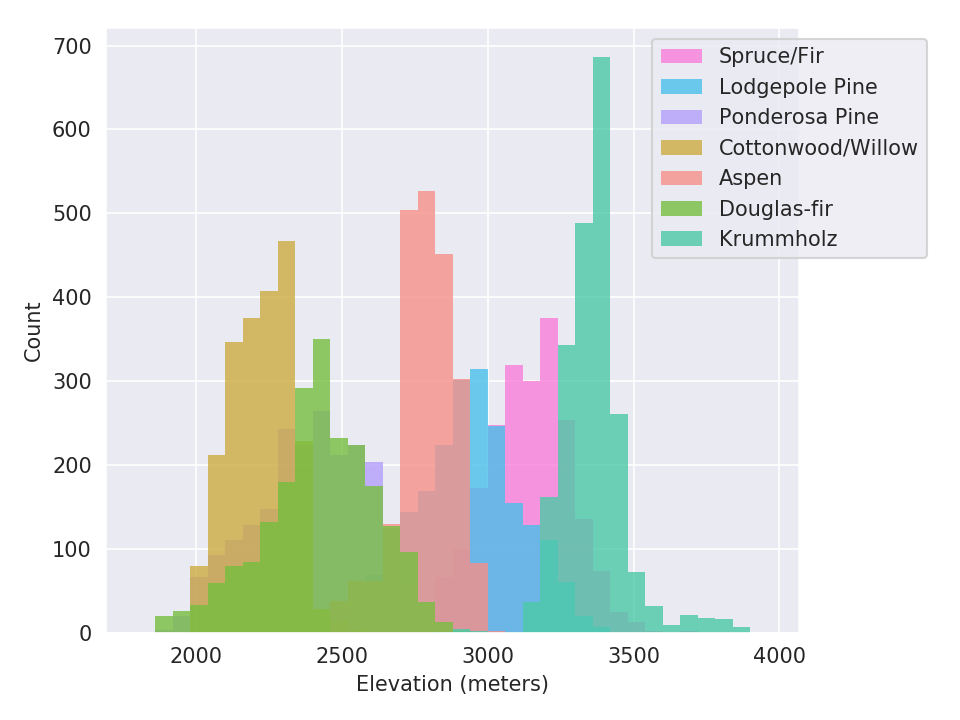

In [12]:
# Plot an Elevation's histogram for each Cover Type
# to check for possible class separation

# Slice by two columns: Elevation and Cover_Type
elevations = train.loc[:, ['Elevation', 'Cover_Type']]
# Dictionary for mapping each integer target label to its string value
covtype_label_name_dict = {1: 'Spruce/Fir',
                           2: 'Lodgepole Pine',
                           3: 'Ponderosa Pine',
                           4: 'Cottonwood/Willow',
                           5: 'Aspen',
                           6: 'Douglas-fir',
                           7: 'Krummholz'}
# It is clear that classes
# 4 (Willow), 5 (Aspen) and 7 (Krummholz) are easily separable
elevation_multiple_covtype_distplot(elevations, covtype_label_name_dict)

In [13]:
# Don't need elevations anymore
print('Dereferencing elevations')
del elevations

Dereferencing elevations


<IPython.core.display.Javascript object>


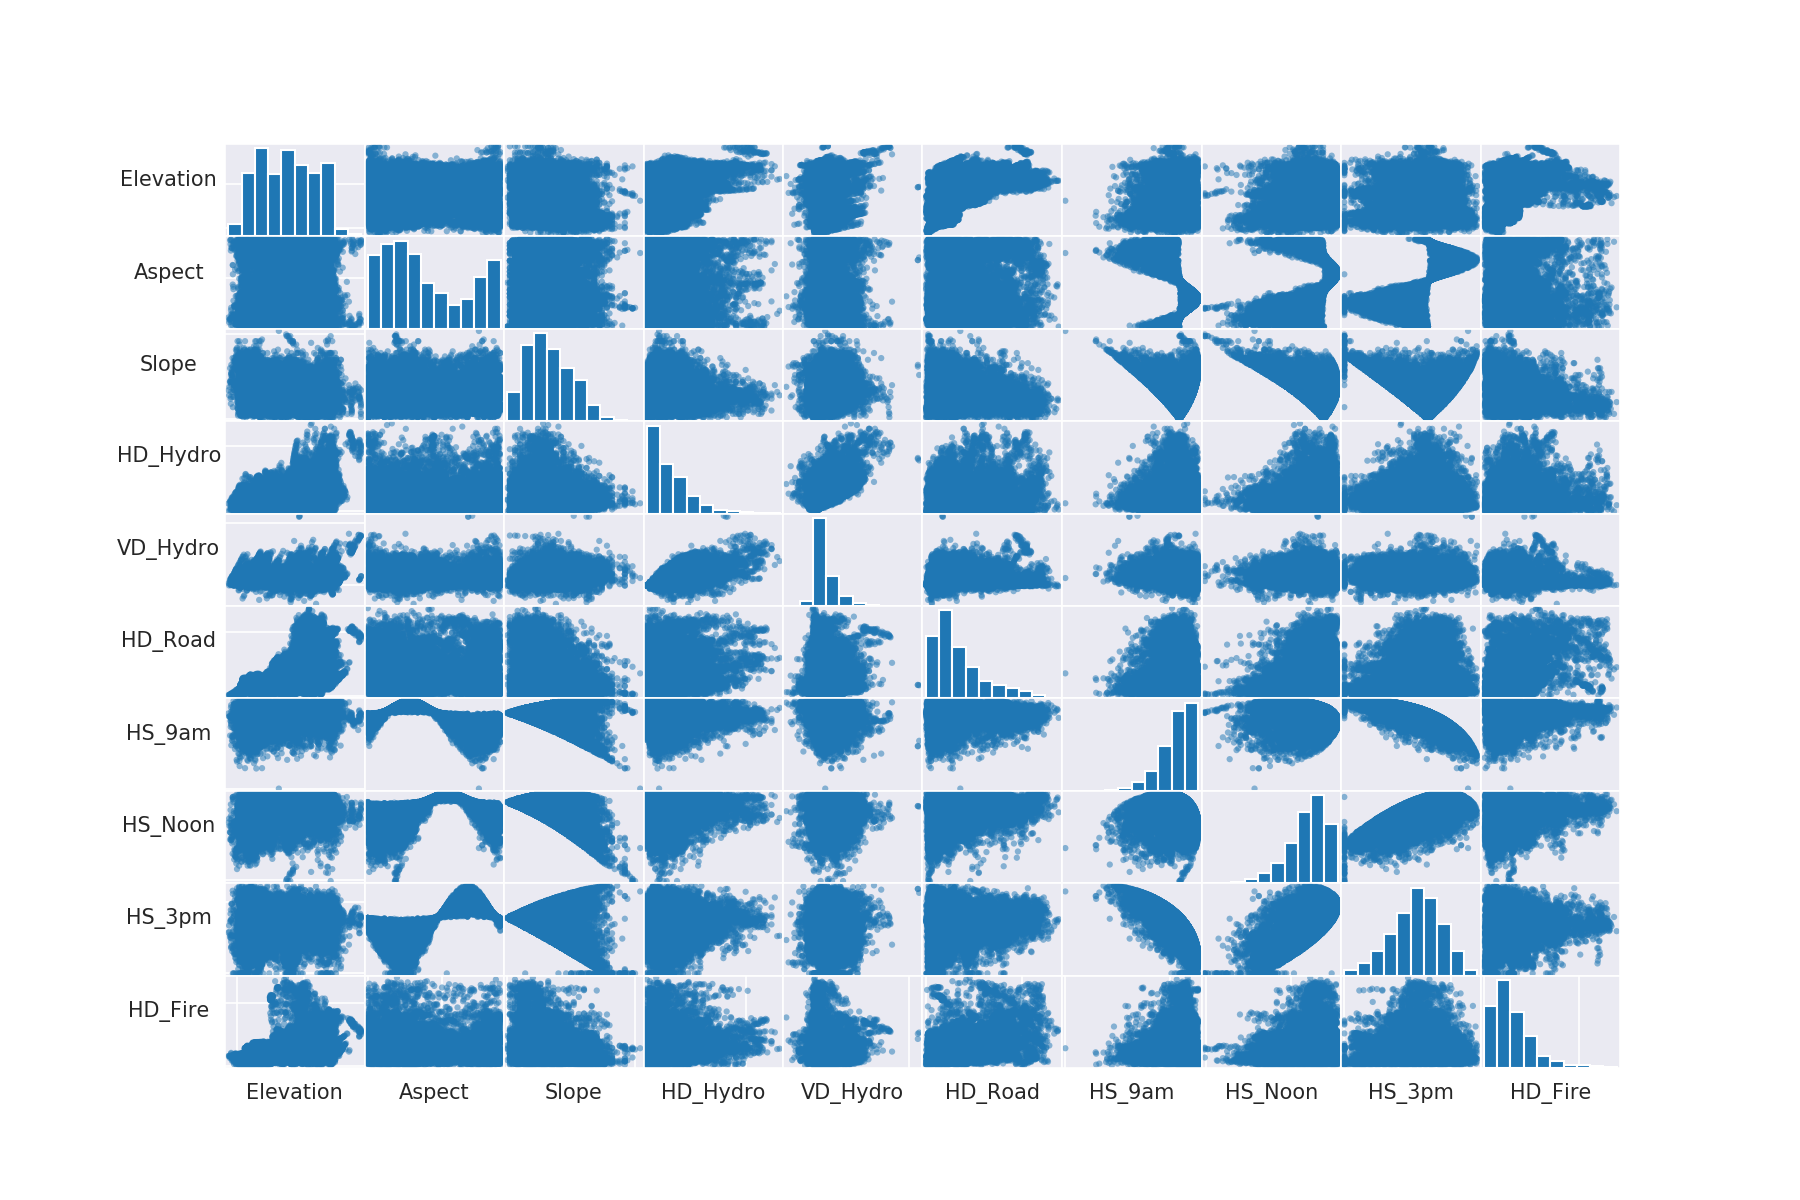

In [14]:
# Since the Elevation looks like a promising feature for Cover Type prediction
# let's check the correlation matrix to see which continuos feature
# depends on the Elevation
# Note that we could have used Chi-Squared Test to check for features
# dependency on Cover Type but it is out of scope for this project
from pandas.plotting import scatter_matrix

# The features we are interested in for the correlation matrix
features_to_check = ['Elevation', 'Aspect',
                     'Slope',
                     'Horizontal_Distance_To_Hydrology',
                     'Vertical_Distance_To_Hydrology',
                     'Horizontal_Distance_To_Roadways',
                     'Hillshade_9am', 'Hillshade_Noon',
                     'Hillshade_3pm',
                     'Horizontal_Distance_To_Fire_Points']
# Same features as above, just with some shorter names
# for visualization purposes
labels_to_plot = ['Elevation', 'Aspect',
                  'Slope', 'HD_Hydro',
                  'VD_Hydro', 'HD_Road',
                  'HS_9am', 'HS_Noon',
                  'HS_3pm', 'HD_Fire']
# Create a dictionary for mapping the labels like this
# {long_label: short_label}
shorter_labels = dict(zip(features_to_check, labels_to_plot))
# Make a copy of the training set because we want to rename
# some columns to fit them on the graph
corr_train = train[features_to_check].copy()
# Do the renaming feeding the mapping dictionary we created
corr_train.rename(columns=shorter_labels, inplace=True)
# Grab the AxesSubplots handle to modify labels padding and rotation
axes = scatter_matrix(corr_train, figsize=(12, 8))
n = len(corr_train.columns)
for x in range(n):
    for y in range(n):
        # for all the axes on the graph..
        ax = axes[x,y]
        # rotate the y-axis labels by 0 (horizontally)..
        ax.yaxis.label.set_rotation(0)
        # add some padding between the labels and their subgraph..
        ax.xaxis.labelpad = 0
        ax.yaxis.labelpad = 20
        # and hide axes value ranges
        ax.set_yticklabels([])
        ax.set_xticklabels([])

<IPython.core.display.Javascript object>


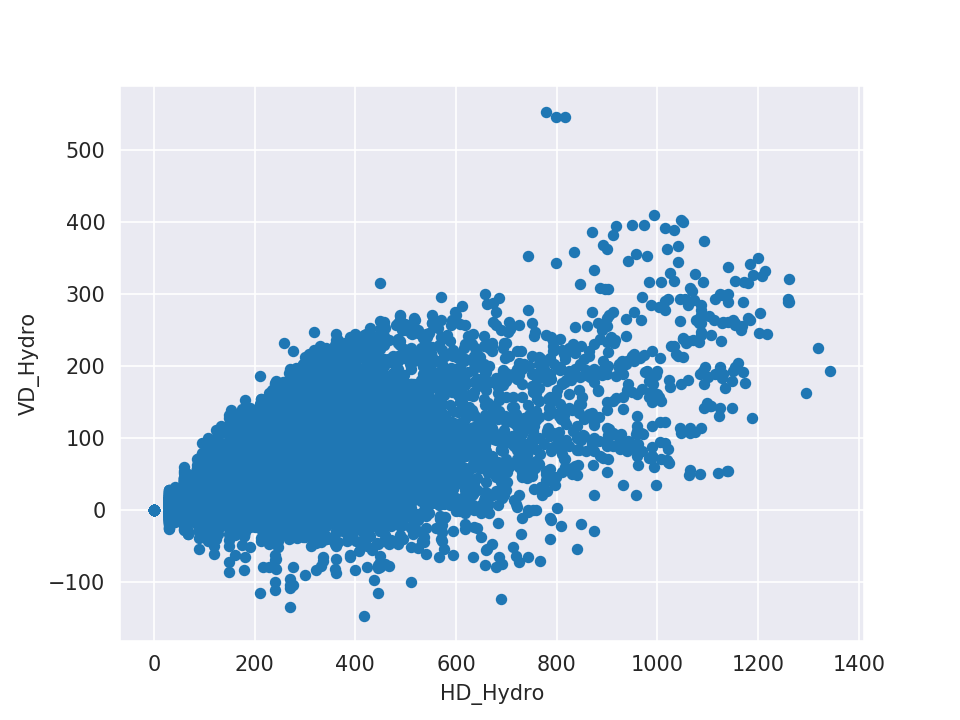

In [15]:
# Let's write down the most correlated features:
# - 'HD_Hydro' and 'VD_Hydro'
# - 'HS_Noon' and 'HS_3pm'
# Plot the same scatter graph zooming on these
corr_train.plot(kind='scatter', x='HD_Hydro', y='VD_Hydro')

<IPython.core.display.Javascript object>


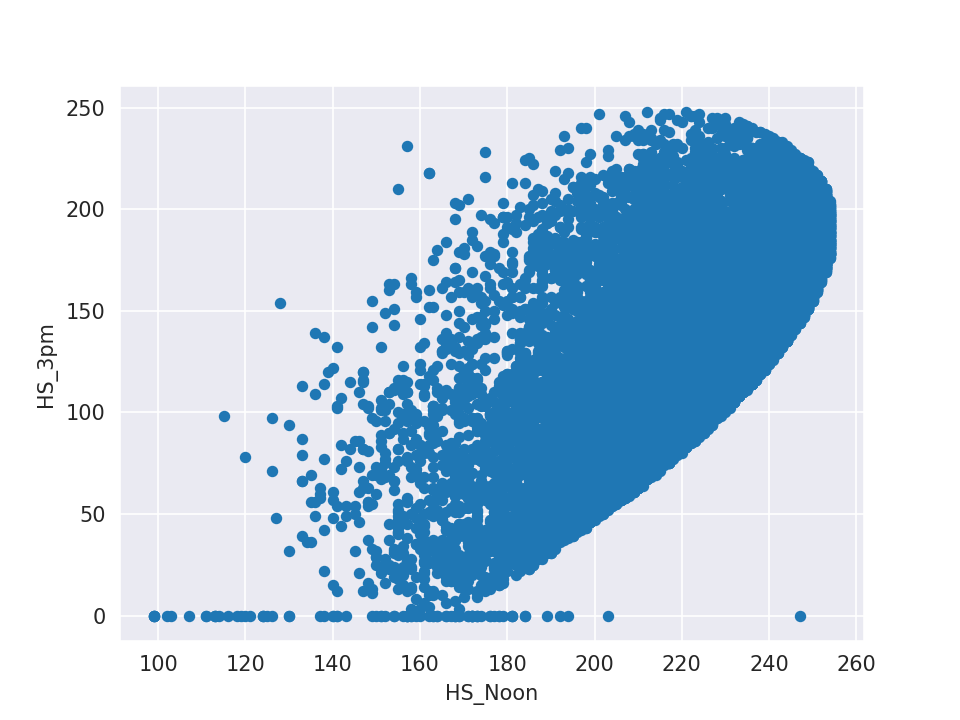

In [16]:
# Looks like there are a lot of HS_3pm equal to zero.
# It could help to impute those with the median
corr_train.plot(kind='scatter', x='HS_Noon', y='HS_3pm')

In [17]:
# Don't need train and corr_train df anymore
# Hopefully the garbage collector will clean them up
# Don't need elevations anymore
print('Dereferencing train and corr_train')
del train
del corr_train

Dereferencing train and corr_train


In [18]:
# Count Hillshade_3pm zeros on the entire dataset
(df_covtype.Hillshade_3pm == 0).astype(int).sum(axis=0)

1338

In [19]:
# Imputing Hillshade_3pm zeros with the median
from sklearn.impute import SimpleImputer

simp = SimpleImputer(missing_values=0, strategy='median')
# fit_transform requires X as a numpy array of shape [n_samples, n_features]
# thus the dataframe column is casted to a numpy array and reshaped
df_covtype.Hillshade_3pm = simp.fit_transform(df_covtype.Hillshade_3pm.values.reshape(-1,1))
# Count the zeros again to check the result
(df_covtype.Hillshade_3pm == 0).astype(int).sum(axis=0)

0

In [20]:
# Let's compute the Euclidean distance to Hydrology
hv_distances_labels = ['Horizontal_Distance_To_Hydrology',
                       'Vertical_Distance_To_Hydrology']
hv_dist_hydro_arr = df_covtype[hv_distances_labels].values
# Perform the Euclidean distance with respect to the origin
# (i.e (0;0) where the water is located)
euc_distance_to_hydro = np.linalg.norm(hv_dist_hydro_arr, axis=1)
# Add the new feature 'Distance_To_Hydrology' to the training set
# just after the 'Slope' feature at index 2
# rounding each distance to two decimal places
df_covtype.insert(3,
                  'Distance_To_Hydrology',
                  np.around(euc_distance_to_hydro, decimals=4))
# Drop the horizontal and vertical distance
df_covtype.drop(columns=hv_distances_labels, inplace=True)

In [21]:
# Check the result
df_covtype.head(2)

,Elevation,Aspect,Slope,Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_1,...,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type
0,2596,51,3,258.0000,510,221,232,148.0,6279,1,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212.0849,390,220,235,151.0,6225,1,...,0,0,0,0,0,0,0,0,0,5


In [22]:
# Perform one hot encoding via get_dummies,
# then drop the integer target label, leaving the one hot encoded labels only
one_hot_covtype = pd.get_dummies(df_covtype.Cover_Type, prefix='CovT')
df_covtype.drop(columns='Cover_Type', inplace=True)
df_covtype_ohe = df_covtype.join(one_hot_covtype)

In [23]:
# Check the resulting shape
df_covtype_ohe.shape

(581012, 60)

In [24]:
# Don't need df_covtype anymore
print('Dereferencing df_covtype')
del df_covtype

Dereferencing df_covtype


In [25]:
# Downcast all features to reduce the overall dataframe dimension

# Get the columns header onto a list
df_covtype_ohe_headers = df_covtype_ohe.columns.values.tolist()
# There is no need to convert the last 7 elements, they are already uint8
# just drop them
df_covtype_ohe_headers = df_covtype_ohe_headers[:-7 or None]
# A list containing the new dtype for each column of interest
features_new_dtype_list = list()
# Iterate through the headers list to assign the new dtype
# for each column
for i in range(len(df_covtype_ohe_headers)):
    if i == 3:
        # Distance_To_Hydrology could fit in float16
        # but float32 works better with mean and std calculations
        features_new_dtype_list.append('float32')
    elif i < 9:
        # First nine features except Distance_To_Hydrology
        # can have int16
        features_new_dtype_list.append('int16')
    else:
        # the remaining ones are binary integers, so uint8
        # is enough
        features_new_dtype_list.append('uint8')
# A dictionary whose keys are the dataframe columns and values
# are the new dtype ( namely, {'Elevation' : 'int16', ...} )
features_new_dtype_mapping = dict(zip(df_covtype_ohe_headers,
                                      features_new_dtype_list))
# Perform the downcasting using the dictionary just created
df_covtype_ohe = df_covtype_ohe.astype(dtype=features_new_dtype_mapping)

In [26]:
# Check the result
df_covtype_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 60 columns):
Elevation                             581012 non-null int16
Aspect                                581012 non-null int16
Slope                                 581012 non-null int16
Distance_To_Hydrology                 581012 non-null float32
Horizontal_Distance_To_Roadways       581012 non-null int16
Hillshade_9am                         581012 non-null int16
Hillshade_Noon                        581012 non-null int16
Hillshade_3pm                         581012 non-null int16
Horizontal_Distance_To_Fire_Points    581012 non-null int16
Wilderness_Area_1                     581012 non-null uint8
Wilderness_Area_2                     581012 non-null uint8
Wilderness_Area_3                     581012 non-null uint8
Wilderness_Area_4                     581012 non-null uint8
Soil_Type_1                           581012 non-null uint8
Soil_Type_2                           581012 no

In [27]:
def train_test_split(df_covtype_ohe):
    '''
    Split the one hot encoded dataset onto training set and test set
    according to UCI's repository guidelines
    '''
    # First 15120 rows for the training set
    X_train = df_covtype_ohe[:15120].copy()
    # The last column is the target label
    X_train, y_train = X_train.iloc[:, :53], X_train.iloc[:, 54:]
    # The remaining rows are for the test set
    X_test = df_covtype_ohe[15121:].copy()
    X_test, y_test = X_test.iloc[:, :53], X_test.iloc[:, 54:]
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(df_covtype_ohe)

In [28]:
# Check shapes consistency
print(f'X_train: {X_train.shape}, X_test: {X_test.shape}, ' \
      f'y_train: {y_train.shape}, y_test: {y_test.shape}')

X_train: (15120, 53), X_test: (565891, 53), y_train: (15120, 6), y_test: (565891, 6)


In [29]:
# Let's standardize the training set and test set.
# Note that we fit the training set only and then transform the test set
# (basically we don't fit AND transform the test set too)
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_train_std = ss.fit_transform(X_train.astype('float64'))
X_test_std = ss.transform(X_test.astype('float64'))

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=0.1, random_state=1, solver='liblinear', multi_class='ovr')
lr.fit(X_train_std, y_train)

print('Logistic Regression, training accuracy: %.2f%%' % (100 * lr.score(X_train_std, y_train)))

# Let's try some feature selection. Most of the features are encoded from categorical data,
# thus Chi Squared test can help us identify dependent/independent features.
# For continuous features, a correlation matrix would have been appropriate
# Note that Chi Squared test works on non-negative values only
features_to_test = ['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
                    'Wilderness_Area_1', 'Wilderness_Area_2',
                    'Wilderness_Area_3', 'Wilderness_Area_4']
all_soil_types = ['Soil_Type_' + str(i) for i in np.arange(1,41)]
# 47 features will be used for Chi Squared testing
features_to_test = features_to_test + all_soil_types

from sklearn.feature_selection import SelectKBest, chi2

# k=10 to get the first 10 best features from Chi Squared test
chi2_selector = SelectKBest(chi2, k=10)
chi2_selector.fit(X_train[features_to_test], y_train)

# Check the scores
chi2_selector.scores_

best_features_filter = chi2_selector.get_support()
features_to_test = np.array(features_to_test)
features_to_test[best_features_filter]